<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import lightgbm as lgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler 
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
def fun_date(data):
    print('**Общая информация датафрейма**')
    print(data.info())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Просмотр статистических данных**')
    print(data.describe())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод рандомных строк датафрейма**')
    print(data.sample(n=3, random_state=1))
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод первых пяти строк датафрейма**')
    print(data.head())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва дубликатов датафрейма**')
    print(data.duplicated().sum())
    print('-------------------------------------------------------------------------------------------------------------')
    print('**Вывод количесва пропущеных значений датафрейма**')
    print(data.isnull().sum())
    #print(msno.heatmap(data))
    print('-------------------------------------------------------------------------------------------------------------')
print(fun_date(data))

**Общая информация датафрейма**
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None
-------------------------------------------------------------------------------------------------------------
**Просмотр статистических данных**
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000
-------------------------------------------------------------------------------------------------------------
**Вывод рандомных строк датафрейма**
                     num_orders
datetime                       
2018-06-14 20:50:00          29
2018-06-21 19:40:00           4
2018-07-31 05:00:00           7
-------------------------------------------------------------------------------------------------------------
**В

In [5]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


<div class="alert alert-info"> 
<b>Сделали предобработку данных:</b>
    
- выполнили ресемплирование по одному часу;
    
- выявили дубликаты - чистить их не будем, тк очевидно, что они есть, потому что в конкретный час может быть одинаковое количесво заказов;

</div>


## Анализ

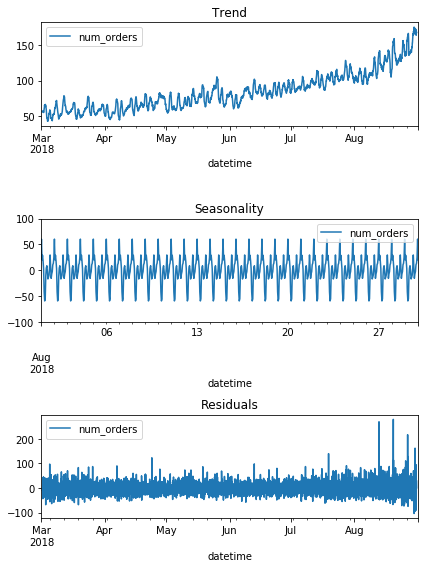

In [6]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlim('2018-08-01', '2018-08-30')
plt.ylim(-100, 100)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

<div class="alert alert-info"> 

    
- По тренду можно заметить, что летом спрос на такси больше, что давольно странно - большинство, как мне казалось, больше пешком или на самокатах передвигаются(по крайней мере в Мск)
    
- По сезонности видно, как спрос на такси больше становится вечером, народ идет по ресторанам

    
В реальности бизнеса есть все три вида сезонности:

1) дневная сезонность - данные собраны по дням, т.е. будни и выходные имеют разные продажи
2) внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером
3) месячная сезонность: когда продажи лета и осени - разные.

И если строить прогноз на длительный период времени, то без учёта всех видов сезонности - не обойтись
Например: есть в данных восходящий тренд. Но вопрос такой возникает:
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)
Ответ на вопрос - не протой на имеющихся данных - у нас данных меньше года. А это означает, что месячную сезонность нам не просто вычислить адекватно - т.е. не внести в модель корректтировки месяцев(
Поэтому, я бы дал такой совет:
на горизонте прогнозирования - несколько часов или дней - можно предположить что у нас тренд.
А если строить прогноз на несколько недель - вот тут утверждать наличие тренда надо с большой осторожностью))))

Ну, а если вернуться к постановке задаче - построить прогноз на час (очень маленький горизонт), то двух сезонности может и хватить.

</div>


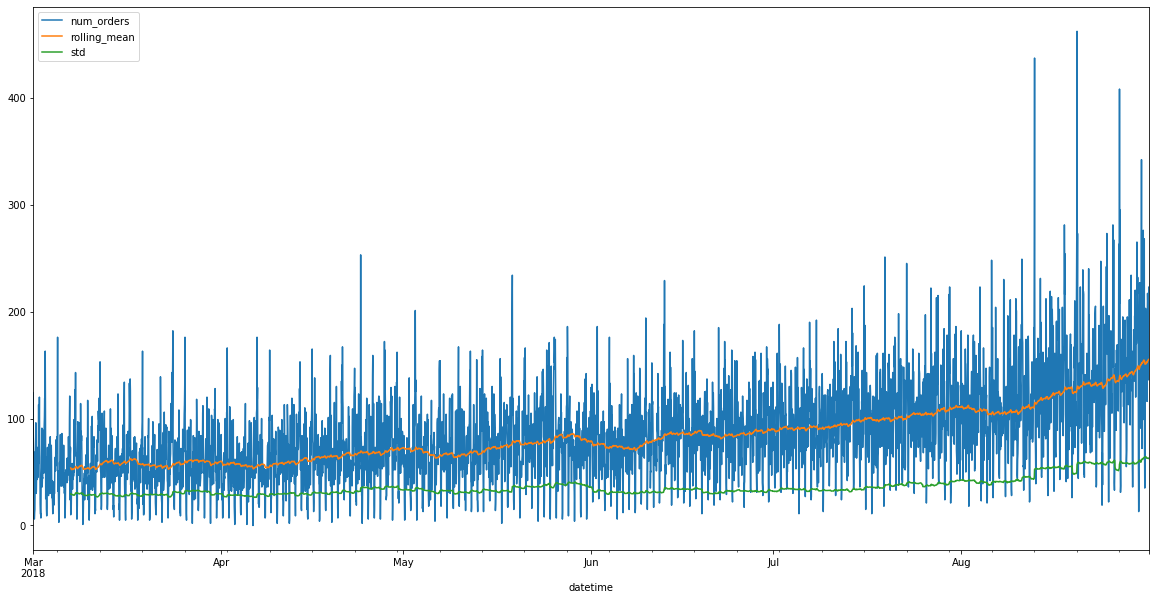

In [7]:

data['rolling_mean'] = data.rolling(150).mean()
data['std'] = data['num_orders'].rolling(150).std()
data.plot(figsize=[20, 10])


<div class="alert alert-info"> Отметим, что ряд - стационарный

## Обучение

<font color='blue'>Функция rmse для обучающей выборки

In [8]:
def hq_train (model):
    model.fit(train_features,train_target)
    train_predict=model.predict(train_features)
    mse=mean_squared_error(train_target, train_predict)
    rmse=mse**0.5
    print("Точность модели", model.score(train_features,train_target))
    print('RMSE модели:', rmse)

<font color='blue'>Функция rmse для тестовой выборки

In [9]:
def hq_test (model):
    model.fit(test_features,test_target)
    test_predict=model.predict(test_features)
    mse=mean_squared_error(test_target, test_predict)
    rmse=mse**0.5
    print("Точность модели", model.score(test_features, test_target))
    print('RMSE модели:', rmse)

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 6, 10)
print(data.head())

                     num_orders  rolling_mean  std  hour  dayofweek  lag_1  \
datetime                                                                     
2018-03-01 00:00:00         124           NaN  NaN     0          3    NaN   
2018-03-01 01:00:00          85           NaN  NaN     1          3  124.0   
2018-03-01 02:00:00          71           NaN  NaN     2          3   85.0   
2018-03-01 03:00:00          66           NaN  NaN     3          3   71.0   
2018-03-01 04:00:00          43           NaN  NaN     4          3   66.0   

                     lag_2  lag_3  lag_4  lag_5  lag_6  
datetime                                                
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN  
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN  
2018-03-01 02:00:00  124.0    NaN    NaN    NaN    NaN  
2018-03-01 03:00:00   85.0  124.0    NaN    NaN    NaN  
2018-03-01 04:00:00   71.0   85.0  124.0    NaN    NaN  


In [11]:
train, test = train_test_split(data, shuffle=False, test_size=0.08)
train = train.dropna()
print(train.shape)
print(test.shape)

(3913, 11)
(354, 11)


<font color='blue'>Разбили выборку 4:1

In [12]:
train_features=train.drop('num_orders', axis=1)
train_features=train_features.fillna(value=None, method="bfill")
train_target=train['num_orders']

test_features=test.drop('num_orders', axis=1)
test_features=test_features.fillna(value=None, method="bfill")
test_target=test['num_orders']


<font color='blue'>Разбили данные на таргеты и фичи

In [13]:
model_lr = LinearRegression(copy_X=True, fit_intercept=False, normalize=True)
model_lr.fit(train_features, train_target)
tr_pred=model_lr.predict(train_features)
tt_pred=model_lr.predict(test_features)
print("MAE обучающей выборки:", mean_absolute_error(train_target, tr_pred))
print("MAE тестовой выборки: ", mean_absolute_error(test_target, tt_pred))
hq_train(model_lr)

MAE обучающей выборки: 24.366537132494397
MAE тестовой выборки:  39.680014233573424
Точность модели 0.360816920788139
RMSE модели: 31.598417534111135


In [14]:
model_sgd = SGDRegressor(alpha= 0.5, max_iter = len(data), random_state=12345)
model_sgd.fit(train_features, train_target)
hq_train(model_sgd)

Точность модели -1.3997282346969006e+23
RMSE модели: 14786812304167.121


In [15]:
model_cat=CatBoostRegressor(iterations=15,learning_rate=1,depth=5, random_seed=12345)
model_cat.fit(train_features, train_target)
hq_train(model_cat)

0:	learn: 28.5709398	total: 48.5ms	remaining: 679ms
1:	learn: 26.6413224	total: 50ms	remaining: 325ms
2:	learn: 26.4659433	total: 51ms	remaining: 204ms
3:	learn: 25.7428124	total: 52.3ms	remaining: 144ms
4:	learn: 24.6699558	total: 53.4ms	remaining: 107ms
5:	learn: 24.0431859	total: 56.9ms	remaining: 85.3ms
6:	learn: 23.7626913	total: 63.6ms	remaining: 72.7ms
7:	learn: 23.4549288	total: 65.4ms	remaining: 57.2ms
8:	learn: 22.9683524	total: 67ms	remaining: 44.7ms
9:	learn: 22.4440086	total: 68.3ms	remaining: 34.1ms
10:	learn: 22.1914201	total: 69.5ms	remaining: 25.3ms
11:	learn: 21.7676736	total: 70.7ms	remaining: 17.7ms
12:	learn: 21.5371469	total: 71.8ms	remaining: 11ms
13:	learn: 21.3581628	total: 73ms	remaining: 5.22ms
14:	learn: 21.1719884	total: 74.2ms	remaining: 0us
0:	learn: 28.5709398	total: 1.53ms	remaining: 21.4ms
1:	learn: 26.6413224	total: 3.08ms	remaining: 20ms
2:	learn: 26.4659433	total: 4.2ms	remaining: 16.8ms
3:	learn: 25.7428124	total: 5.43ms	remaining: 14.9ms
4:	learn:

In [16]:
model_LGBM = lgb.LGBMRegressor(n_estimators=100, max_depth=5, boosting_type = 'gbdt', random_state=12345)
model_LGBM.fit(train_features, train_target)
hq_train(model_LGBM)

Точность модели 0.7901292839674243
RMSE модели: 18.106254512548315


In [17]:
model = DecisionTreeClassifier(random_state=12345)
best_model = None
best_result = 0
best_leaf = 0
best_depth = 0
best_split = 2

for split in range(3, 11):
    for leaf in range(1, 11):
        for depth in range (1, 15):
            model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_leaf=leaf, min_samples_split= split)
            model_dtc.fit(train_features, train_target) 
            result = model_dtc.score(test_features, test_target)
            if result < best_result:
                best_model = model_dtc
                best_result = result
                best_leaf = leaf
                best_depth = depth
                best_split=split
print("Точность наилучшей модели :", best_result, 
      "минимум значений в листе:", best_leaf, "Максимальная глубина:", depth, "лучшее разделение:", best_split)
hq_train(model_dtc)

Точность наилучшей модели : 0 минимум значений в листе: 0 Максимальная глубина: 14 лучшее разделение: 2
Точность модели 0.17837975977510862
RMSE модели: 33.341525102973016


In [18]:
#Случайный лес
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 101, 10):
    for depth in range (1, 15):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rfc.fit(train_features, train_target) 
        result = model_rfc.score(test_features, test_target)
        if result < best_result:
            best_model = model_rfc
            best_result = result
            best_est = est
            best_depth = depth

print("Точность наилучшей модели :", best_result,"Количество деревьев:", best_est, "Максимальная глубина:", depth)
hq_train(model_dtc)

Точность наилучшей модели : 0 Количество деревьев: 0 Максимальная глубина: 14
Точность модели 0.17837975977510862
RMSE модели: 33.341525102973016


<div class="alert alert-info"> По всем показателям, лидирует CatBoost и LGBM

## Тестирование

In [19]:
test_target 

datetime
2018-08-17 06:00:00     43
2018-08-17 07:00:00     69
2018-08-17 08:00:00    103
2018-08-17 09:00:00    123
2018-08-17 10:00:00    160
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 354, dtype: int64

In [20]:
print('Линейная регрессия')
hq_test(model_lr)

Линейная регрессия
Точность модели 0.2958045693560283
RMSE модели: 50.86843964069402


In [21]:
print('CatBoost')
hq_test(model_cat)

CatBoost
0:	learn: 49.8965556	total: 1.18ms	remaining: 16.6ms
1:	learn: 47.2493451	total: 2.78ms	remaining: 18.1ms
2:	learn: 43.2980765	total: 4.23ms	remaining: 16.9ms
3:	learn: 40.9801167	total: 4.9ms	remaining: 13.5ms
4:	learn: 39.7220746	total: 5.86ms	remaining: 11.7ms
5:	learn: 38.2645912	total: 6.96ms	remaining: 10.4ms
6:	learn: 35.8198609	total: 7.94ms	remaining: 9.08ms
7:	learn: 34.6100837	total: 9.47ms	remaining: 8.29ms
8:	learn: 31.3760317	total: 10.6ms	remaining: 7.05ms
9:	learn: 29.3353622	total: 11.8ms	remaining: 5.88ms
10:	learn: 27.7411019	total: 13.2ms	remaining: 4.8ms
11:	learn: 26.5212398	total: 14.7ms	remaining: 3.68ms
12:	learn: 24.9403748	total: 47.5ms	remaining: 7.31ms
13:	learn: 24.6623807	total: 48.8ms	remaining: 3.48ms
14:	learn: 23.8263220	total: 49.9ms	remaining: 0us
Точность модели 0.8455064392898269
RMSE модели: 23.82632196619841


In [22]:
print('LGBM')
hq_test(model_LGBM)

LGBM
Точность модели 0.889957000665549
RMSE модели: 20.10865505492699


<div class="alert alert-info">По проведенным анализам лучше всего себя показали модели с градиентным бустингом, думаю с помощью кросс-валидации можно еще больше улучшить, но это уже совсем другая история)

In [39]:
def graph (model):
    model.fit(test_features,test_target)
    test_predict=model.predict(test_features)
    predictions = pd.Series(test_predict)
    predictions.index = test_target.index
    
    
    fig2, ax = plt.subplots(figsize=(20, 10))
    ax = sns.lineplot(data=test_target, label='Реальные')
    sns.lineplot(data=predictions, color='green', label='Предсказанные')
    plt.xticks(rotation=90)
    plt.xlim('2018-08-17', '2018-08-31')
    plt.title('Результаты модели за две недели')
    plt.xlabel('Дата и время')
    plt.ylabel('Число заказов');

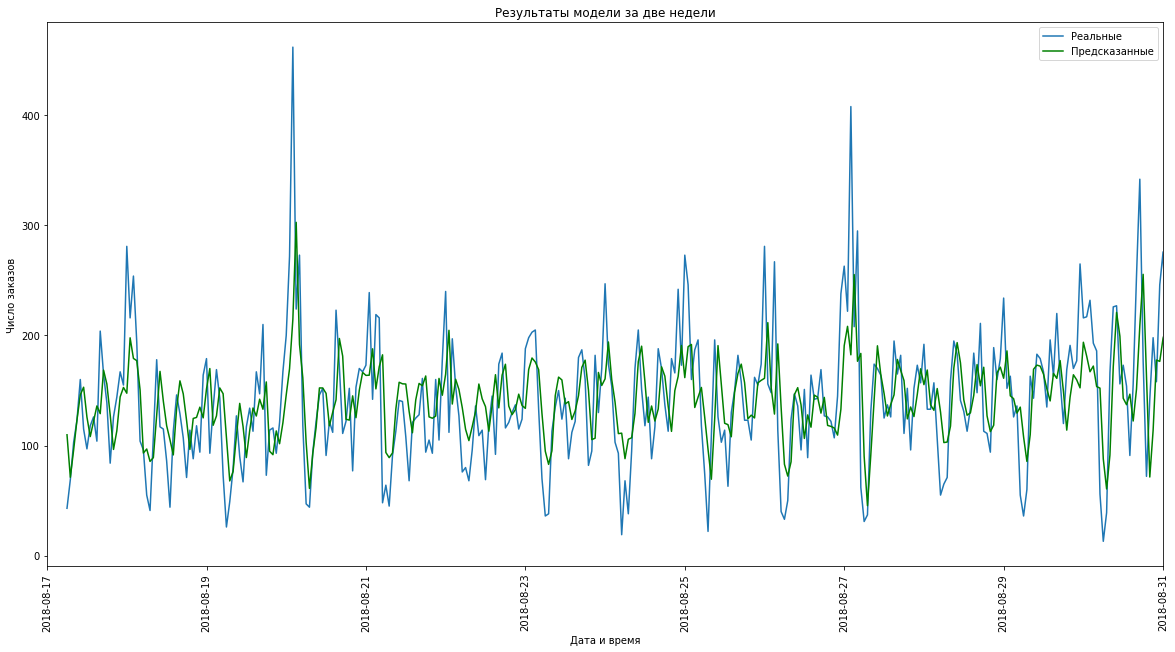

In [40]:
graph(model_lr)

0:	learn: 49.8965556	total: 795us	remaining: 11.1ms
1:	learn: 47.2493451	total: 1.53ms	remaining: 9.96ms
2:	learn: 43.2980765	total: 2.08ms	remaining: 8.34ms
3:	learn: 40.9801167	total: 2.61ms	remaining: 7.18ms
4:	learn: 39.7220746	total: 3.19ms	remaining: 6.39ms
5:	learn: 38.2645912	total: 3.71ms	remaining: 5.56ms
6:	learn: 35.8198609	total: 4.22ms	remaining: 4.82ms
7:	learn: 34.6100837	total: 4.74ms	remaining: 4.15ms
8:	learn: 31.3760317	total: 5.24ms	remaining: 3.5ms
9:	learn: 29.3353622	total: 5.79ms	remaining: 2.9ms
10:	learn: 27.7411019	total: 6.31ms	remaining: 2.29ms
11:	learn: 26.5212398	total: 6.84ms	remaining: 1.71ms
12:	learn: 24.9403748	total: 7.36ms	remaining: 1.13ms
13:	learn: 24.6623807	total: 7.83ms	remaining: 559us
14:	learn: 23.8263220	total: 8.37ms	remaining: 0us


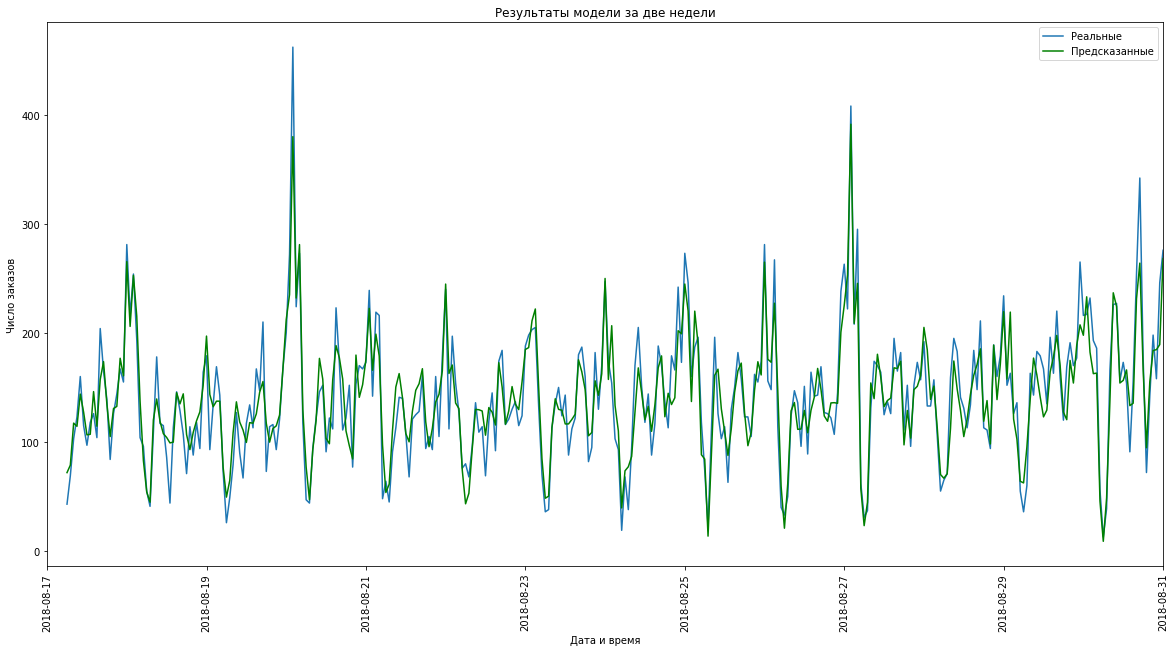

In [41]:
graph(model_cat)

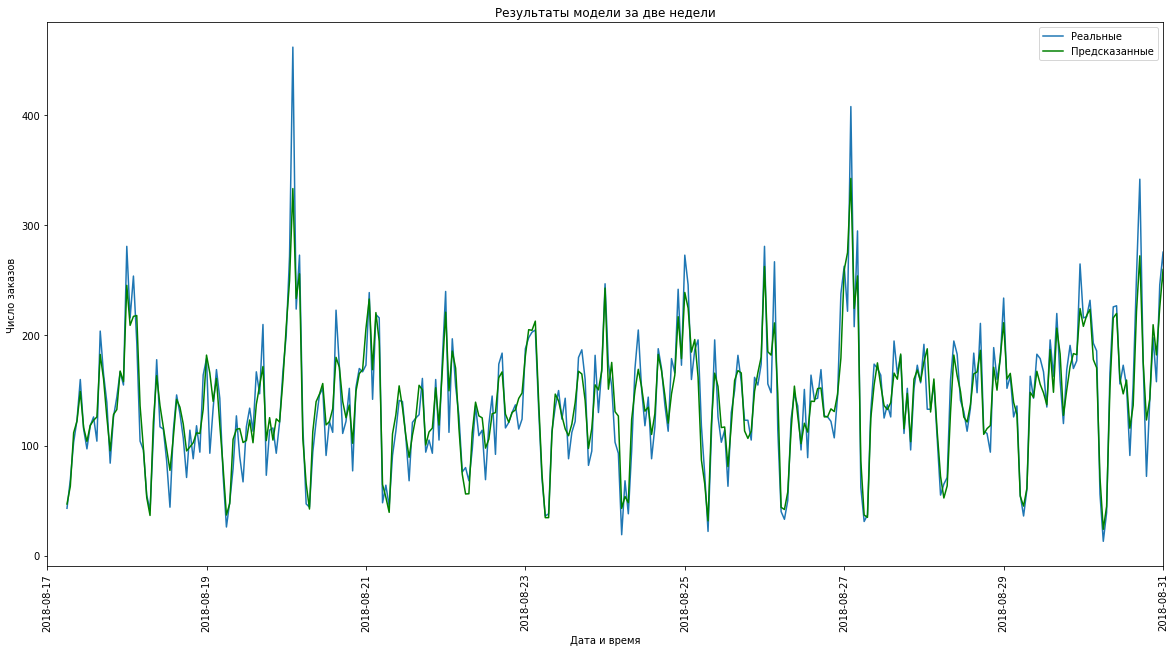

In [42]:
graph(model_LGBM)

**************

<div class="alert alert-info">По итогу предсказания получились плюс минус похожи, модели работают. 
    
Лучшее предсказание у CatBoost, как впринципе и сама модель!